In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from config import setup_wandb_dedicated, setup_wandb_parametrized
from models import MyModel, createSimpleModel

In [305]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [62]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [63]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [64]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

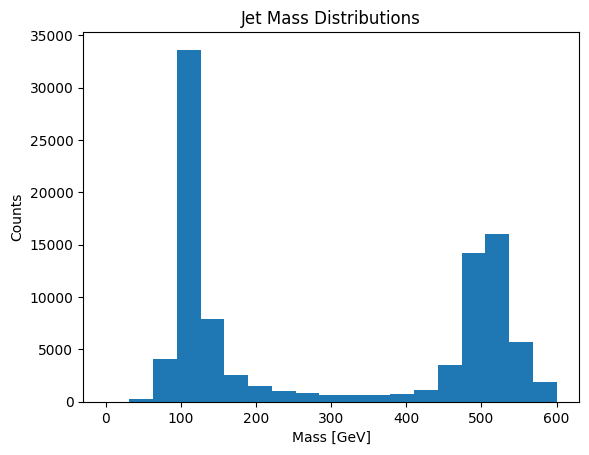

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [4]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array", x_array)

In [5]:
#reads in data 
x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [6]:
np.shape(x[0,0])

(120930, 4)

In [9]:
# x = {}
# x_array_read = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_array.npy",allow_pickle=True)
# mycounter = -1
# for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
#     for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
#         if (m1==0 and m2>0 or m2==0 and m1>0):
#             continue
#         mycounter+=1
#         x[m1,m2] = x_array_read[mycounter]

In [13]:
np.shape(x[0,0])

(120930, 4)

In [8]:
x_vals_100 = np.concatenate([x[0,0],x[1,1]])
y_vals_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)

In [17]:
wandb.init(
    project="Anomaly",
    group="Dedicated2",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 8192,
        "activation_1": "relu",
        "layer_2": 4096,
        "activation_2": "relu",
        "layer_3": 4096,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "mean_squared_error",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024,
        "dropout_rate_1": 0.5,
    }
)

config = wandb.config

In [18]:
model_dedicated = Sequential()
model_dedicated.add(Dense(config.layer_1, input_dim=4, activation=config.activation_1))
model_dedicated.add(Dropout(config.dropout_rate_1))
model_dedicated.add(Dense(config.layer_2, activation=config.activation_2))
model_dedicated.add(Dense(config.layer_3, activation=config.activation_3))
model_dedicated.add(Dense(config.output_layer, activation=config.output_activation))
model_dedicated.compile(loss=config.loss, optimizer=config.optimizer, metrics=[config.metric])
model_dedicated.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              40960     
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_8 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 50,384,897
Trainable params: 50,384,897
Non-trainable params: 0
_________________________________________________________________


In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [20]:
myhistory = model_dedicated.fit(x_vals_100, y_vals_100, epochs=config.epoch,validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback(), es])

Epoch 1/1000
191/193 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9050INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_123920-4jzhwynh/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_123920-4jzhwynh/files/model-best)... Done. 4.8s


193/193 [==============================] - 13s 65ms/step - loss: 0.0695 - accuracy: 0.9051 - val_loss: 0.0561 - val_accuracy: 0.9251
Epoch 2/1000
189/193 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9246

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp39echisl, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpcu6_h5sm, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpxqeb6_kr, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_123920-4jzhwynh/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_123920-4jzhwynh/files/model-best)... wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpvdlwm23i, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


KeyboardInterrupt: 

In [21]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁█
epoch,▁█
loss,█▁
val_accuracy,▁█
val_loss,█▁
accuracy,0.92459
best_epoch,1
best_val_loss,0.0536
epoch,1
loss,0.05549
val_accuracy,0.92733


In [98]:
model_dedicated = Sequential()
model_dedicated.add(Dense(4096, input_dim=4, activation='relu'))
model_dedicated.add(Dense(4096, activation='relu'))
model_dedicated.add(Dense(4096, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [99]:
myhistory = model_dedicated.fit(x_vals_100, y_vals_100, epochs=1000,validation_data=(X_val_100, Y_val_100),batch_size=1024, callbacks = [es])

Epoch 1/1000
193/193 [==============================] - 2s 6ms/step - loss: 0.0668 - accuracy: 0.9090 - val_loss: 0.0531 - val_accuracy: 0.9285
Epoch 2/1000
193/193 [==============================] - 1s 7ms/step - loss: 0.0541 - accuracy: 0.9267 - val_loss: 0.0536 - val_accuracy: 0.9274
Epoch 3/1000
193/193 [==============================] - 1s 5ms/step - loss: 0.0536 - accuracy: 0.9276 - val_loss: 0.0521 - val_accuracy: 0.9292
Epoch 4/1000
193/193 [==============================] - 1s 5ms/step - loss: 0.0533 - accuracy: 0.9275 - val_loss: 0.0546 - val_accuracy: 0.9257
Epoch 5/1000
193/193 [==============================] - 1s 5ms/step - loss: 0.0534 - accuracy: 0.9275 - val_loss: 0.0522 - val_accuracy: 0.9290
Epoch 6/1000
193/193 [==============================] - 1s 5ms/step - loss: 0.0530 - accuracy: 0.9282 - val_loss: 0.0519 - val_accuracy: 0.9294
Epoch 7/1000
193/193 [==============================] - 1s 6ms/step - loss: 0.0530 - accuracy: 0.9285 - val_loss: 0.0519 - val_accuracy:

In [34]:
wandb.finish()

In [100]:
model_dedicated.save("model_100_MSE_3_4096")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_100_MSE_3_4096/assets


In [59]:
preds_mm_list = []
# fpr_mm_list = []
# tpr_mm_list = []

tuple_rates_dedicated_BCE_Optimized = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 3 and j == 3) or (i == 6 and j == 6):
            print(i,j)
            x_vals_mm = np.concatenate([x[0,0],x[i,j]])
            y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(4096, input_dim=4, activation='relu'))
            model.add(Dense(4096, activation='relu'))
            model.add(Dense(4096, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(x_vals_mm, y_vals_mm, epochs=1000,validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            # fpr_mm_list.append(fpr_mm)
            # tpr_mm_list.append(tpr_mm)
            tuple_rates_dedicated_BCE_Optimized[tuple((i, j))] = [fpr_mm, tpr_mm]

0.5 0.5
Epoch 1/1000
192/192 [==============================] - 2s 6ms/step - loss: 0.2920 - accuracy: 0.8740 - val_loss: 0.2710 - val_accuracy: 0.8852
Epoch 2/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8874 - val_loss: 0.2613 - val_accuracy: 0.8931
Epoch 3/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2588 - accuracy: 0.8922 - val_loss: 0.2572 - val_accuracy: 0.8919
Epoch 4/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.8930 - val_loss: 0.2545 - val_accuracy: 0.8939
Epoch 5/1000
192/192 [==============================] - 1s 6ms/step - loss: 0.2557 - accuracy: 0.8927 - val_loss: 0.2544 - val_accuracy: 0.8944
Epoch 6/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2555 - accuracy: 0.8927 - val_loss: 0.2522 - val_accuracy: 0.8950
Epoch 7/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2553 - accuracy: 0.8933 - val_loss: 0.2530 - val_a

In [60]:
len(tuple_rates_dedicated_BCE_Optimized)

4

In [61]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
np.save("tuple_rates_dedicated_BCE_Optimized_3_4096", tuple_rates_dedicated_BCE_Optimized)

#fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [62]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [114]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

144

In [65]:
preds_all_BCE_50 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1],batch_size=1000)
fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1], preds_all_BCE_50)

99/99 [==============================] - 0s 756us/step


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


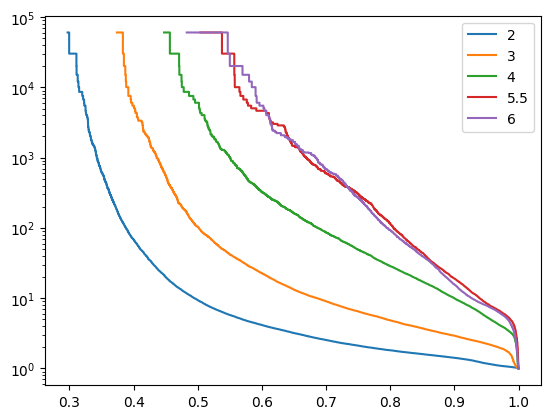

In [181]:
for m in [2, 3, 4, 5.5, 6]:
    something = X_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    preds_all_BCE_50 = model_all_BCE.predict(something,batch_size=1000)
    fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1], preds_all_BCE_50)
    plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))
    plt.legend()
    plt.yscale("log")

In [174]:
np.shape(np.c_[np.ones(len(something)) * 3, np.ones(len(something)) * 3])

(98560, 2)

In [172]:
np.shape(something[:,4:6])

(98560, 2)

In [63]:
preds_all_BCE_100 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

87/87 [==============================] - 0s 757us/step


In [64]:
tuple_rates_dedicated_BCE_Optimized.keys()

dict_keys([(0.5, 0.5), (1, 1), (3, 3), (6, 6)])

Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

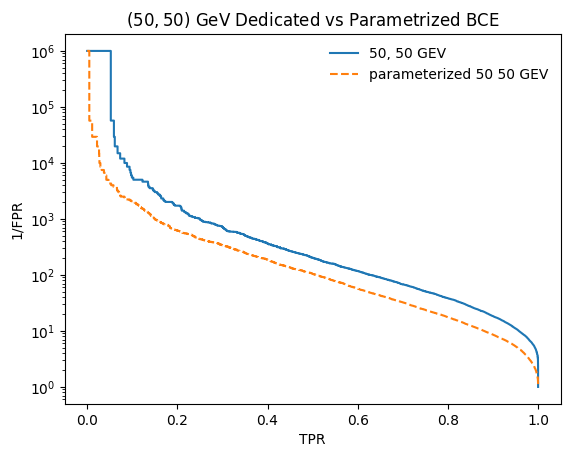

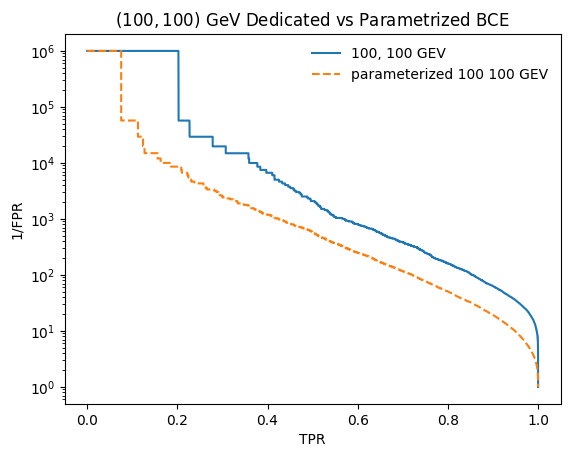

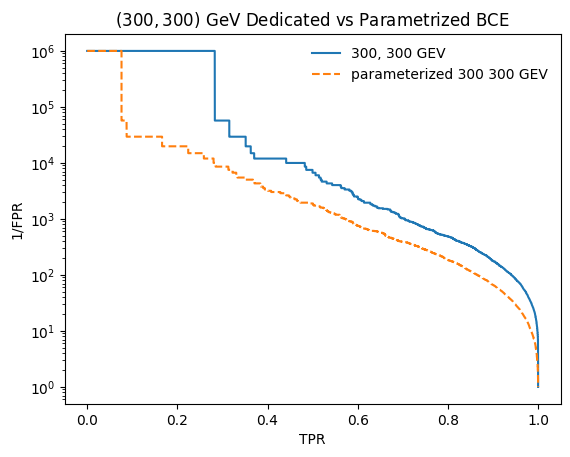

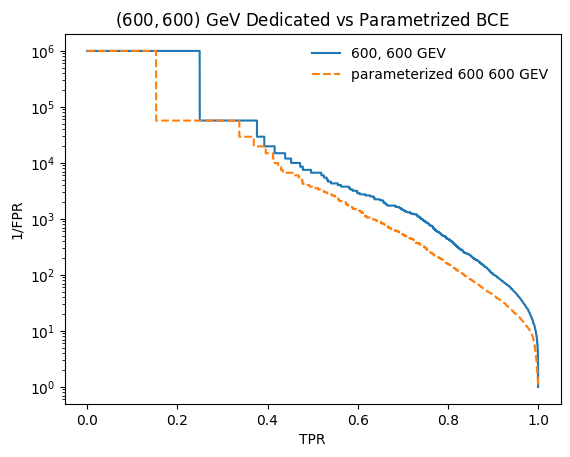

In [66]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated_BCE_Optimized[(0.5,0.5)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(0.5,0.5)][0] + epsilon), label = "50, 50 GEV")
plt.plot(tpr_all_BCE_50, 1./(fpr_all_BCE_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(50,50)$ GeV Dedicated vs Parametrized BCE")

epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated_BCE_Optimized[(1,1)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated_BCE_Optimized[(3,3)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")


plt.figure()
plt.plot(tuple_rates_dedicated_BCE_Optimized[(6,6)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

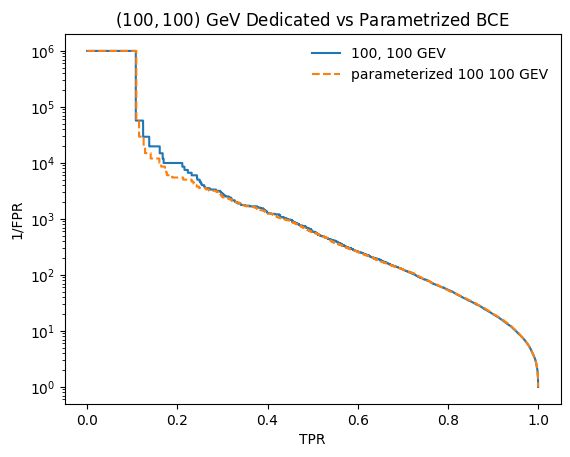

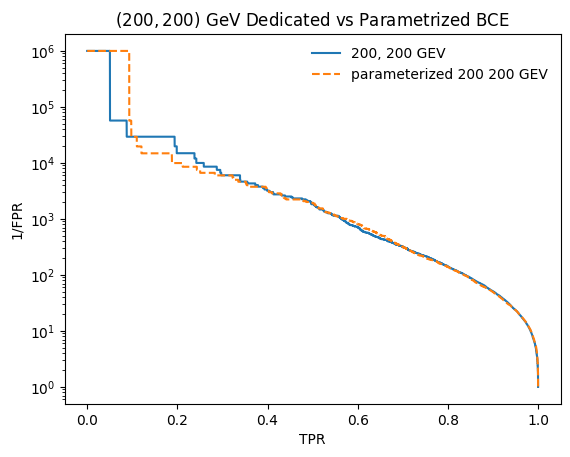

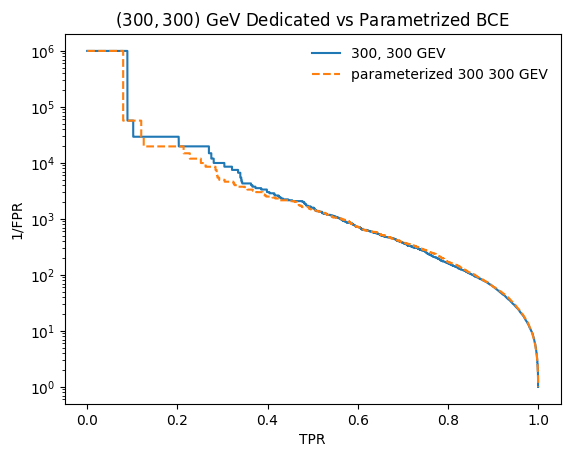

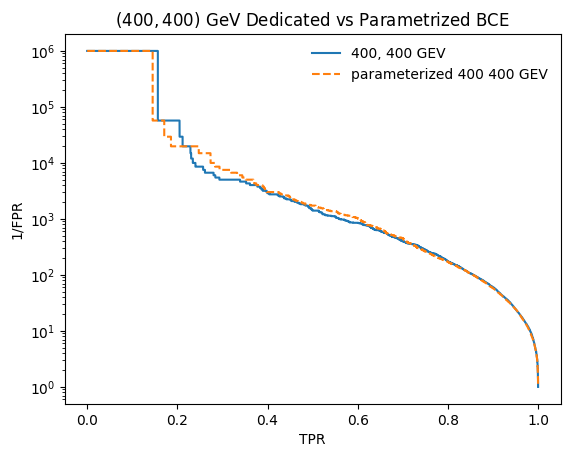

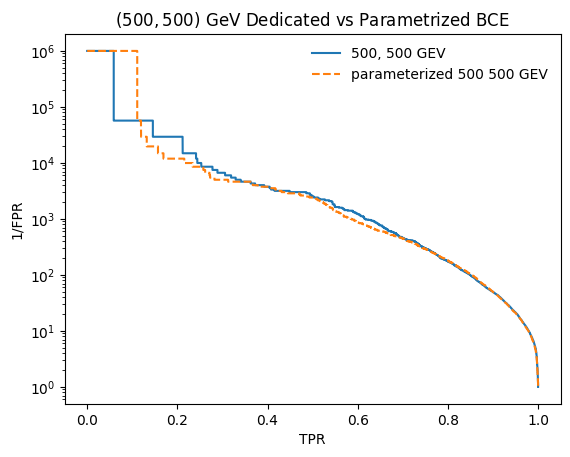

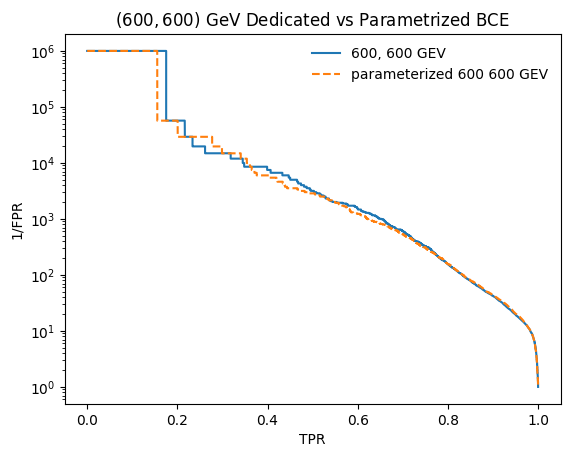

In [116]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Text(0.5, 1.0, '$(m_{B},m_{C})$ GeV Dedicated BCE')

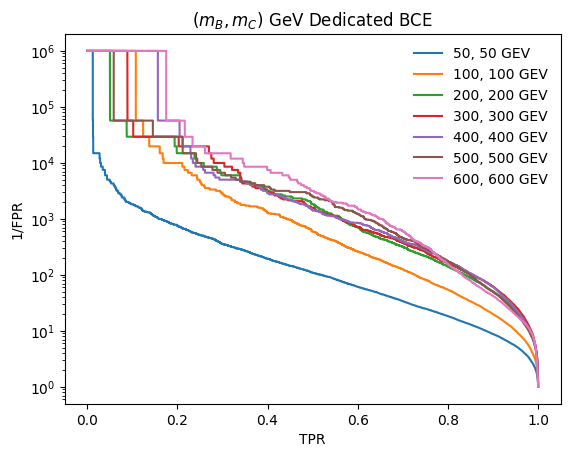

In [120]:
epsilon = 1e-6
plt.plot(tuple_rates_dedicated[(0.5,0.5)][1], 1./(tuple_rates_dedicated[(0.5,0.5)][0] + epsilon), label = "50, 50 GEV")
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ GeV Dedicated BCE")

Text(0.5, 1.0, '$(m_{B},m_{C})$ GeV Dedicated BCE Optimized')

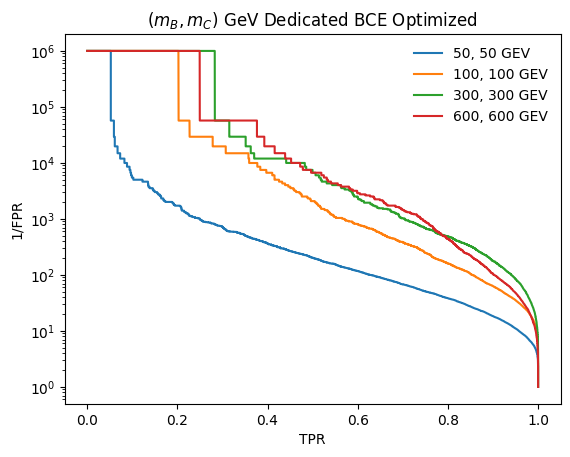

In [68]:
epsilon = 1e-6
plt.plot(tuple_rates_dedicated_BCE_Optimized[(0.5,0.5)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(0.5,0.5)][0] + epsilon), label = "50, 50 GEV")
plt.plot(tuple_rates_dedicated_BCE_Optimized[(1,1)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tuple_rates_dedicated_BCE_Optimized[(3,3)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tuple_rates_dedicated_BCE_Optimized[(6,6)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(6,6)][0] + epsilon), label = "600, 600 GEV")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ GeV Dedicated BCE Optimized")

Text(0.5, 1.0, '$(m_{A},m_{B})$ GeV Dedicated vs Parametrized BCE')

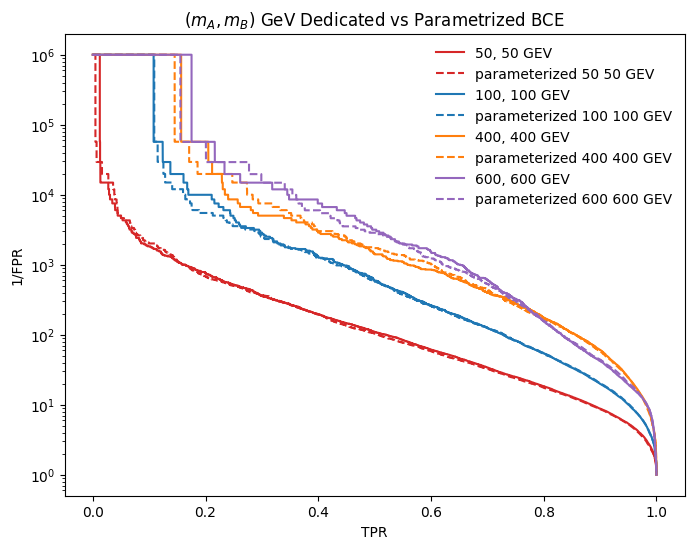

In [132]:
plt.figure(figsize = (8, 6))
epsilon = 1e-6
plt.plot(tuple_rates_dedicated[(0.5,0.5)][1], 1./(tuple_rates_dedicated[(0.5,0.5)][0] + epsilon), label = "50, 50 GEV", color = "#d62728")
plt.plot(tpr_all_BCE_50, 1./(fpr_all_BCE_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed', color = "#d62728")

plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV", color = "#1f77b4")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed', color = "#1f77b4")

plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV", color = "#ff7f0e")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed', color = "#ff7f0e")

plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV", color = "#9467bd")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed', color = "#9467bd")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{A},m_{B})$ GeV Dedicated vs Parametrized BCE")

Text(0.5, 1.0, '$(m_{A},m_{B})$ GeV Dedicated vs Parametrized BCE')

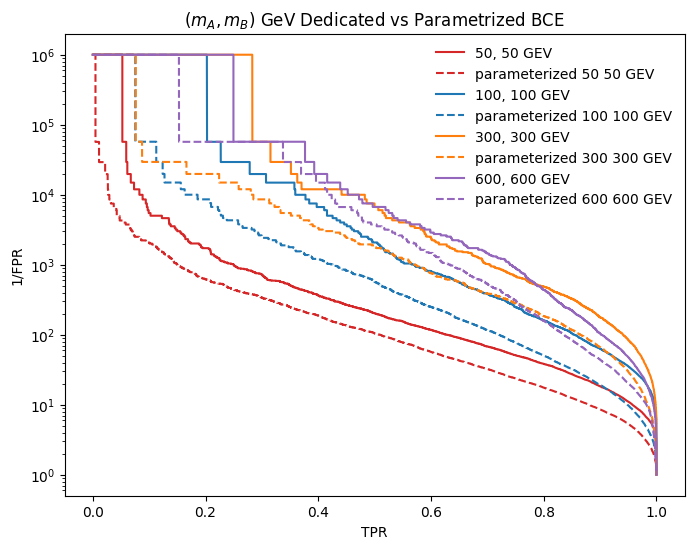

In [70]:
plt.figure(figsize = (8, 6))
epsilon = 1e-6
plt.plot(tuple_rates_dedicated_BCE_Optimized[(0.5,0.5)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(0.5,0.5)][0] + epsilon), label = "50, 50 GEV", color = "#d62728")
plt.plot(tpr_all_BCE_50, 1./(fpr_all_BCE_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed', color = "#d62728")

plt.plot(tuple_rates_dedicated_BCE_Optimized[(1,1)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(1,1)][0] + epsilon), label = "100, 100 GEV", color = "#1f77b4")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed', color = "#1f77b4")

plt.plot(tuple_rates_dedicated_BCE_Optimized[(3,3)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(3,3)][0] + epsilon), label = "300, 300 GEV", color = "#ff7f0e")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed', color = "#ff7f0e")

plt.plot(tuple_rates_dedicated_BCE_Optimized[(6,6)][1], 1./(tuple_rates_dedicated_BCE_Optimized[(6,6)][0] + epsilon), label = "600, 600 GEV", color = "#9467bd")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed', color = "#9467bd")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{A},m_{B})$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

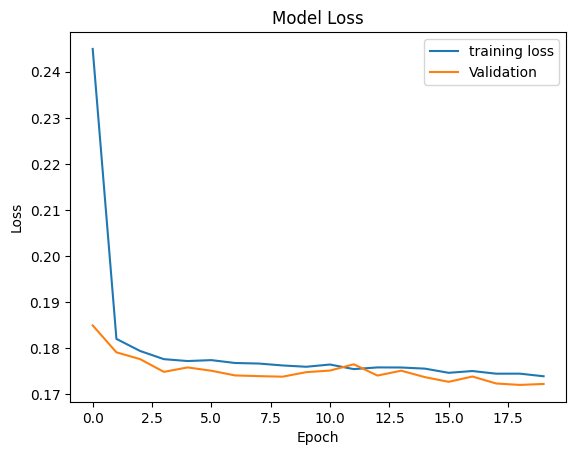

In [255]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


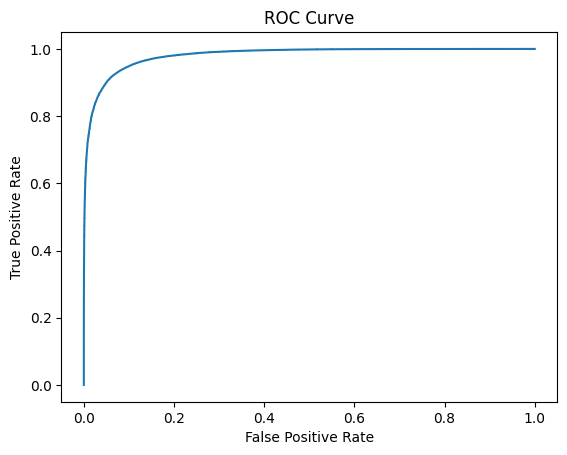

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [833]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all",x_vals_all)
    np.save("y_vals_all",y_vals_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [920]:
x_vals_qq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_vals_qq.npy")
y_vals_qq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/y_vals_qq.npy")

In [1032]:
np.shape(x_vals_qq)

(27188652, 8)

In [1033]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_vals_qq, y_vals_qq, test_size=0.5)

In [25]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [26]:
np.shape(x_vals_all)

(27188652, 6)

In [27]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [28]:
wandb.init(
    project="Anomaly",
    group="Parametrized2",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 4096,
        "activation_1": "relu",
        "layer_2": 4096,
        "activation_2": "relu",
        "layer_3": 4096,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "mean_squared_error",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024
    }
)

config_parametrized = wandb.config

In [37]:
# model_qq = Sequential()
# model_qq.add(Dense(256, input_dim=8, activation='swish'))
# model_qq.add(BatchNormalization())
# model_qq.add(Dense(256, activation='swish'))
# model_qq.add(BatchNormalization())
# model_qq.add(Dense(256, activation='swish'))
# model_qq.add(BatchNormalization())
# model_qq.add(Dense(1, activation='sigmoid'))
# opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
# model_qq.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=['accuracy'])

# myhistory_qq = model_qq.fit(x_vals_qq, y_vals_qq, epochs=20,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024)

In [929]:
#model_qq.save('model_qq_v2')

INFO:tensorflow:Assets written to: model_qq_v2/assets


In [1031]:
#model_qq = tf.keras.models.load_model('model_qq_BCE')

In [29]:
model_all = Sequential()
model_all.add(Dense(config_parametrized.layer_1, input_dim=6, activation=config_parametrized.activation_1))
model_all.add(Dense(config_parametrized.layer_2, activation=config_parametrized.activation_2))
model_all.add(Dense(config_parametrized.layer_3, activation=config_parametrized.activation_3))
model_all.add(Dense(config_parametrized.output_layer, activation=config_parametrized.output_activation))
model_all.compile(loss=config_parametrized.loss, optimizer=config_parametrized.optimizer, metrics=['accuracy'])

In [30]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=config_parametrized.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config_parametrized.batch_size*5, callbacks = [WandbCallback(), es])

Epoch 1/1000
5307/5311 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9334INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.2s


5311/5311 [==============================] - 89s 16ms/step - loss: 0.0498 - accuracy: 0.9334 - val_loss: 0.0476 - val_accuracy: 0.9362
Epoch 2/1000
  85/5311 [..............................] - ETA: 1:13 - loss: 0.0480 - accuracy: 0.9356

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpg70s2jh0, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp3z17ulva, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp4rfnu1df, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 570/5311 [==>...........................] - ETA: 1:03 - loss: 0.0478 - accuracy: 0.9360

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmph5e7adx1, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5310/5311 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9361INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.2s


5311/5311 [==============================] - 88s 16ms/step - loss: 0.0477 - accuracy: 0.9361 - val_loss: 0.0473 - val_accuracy: 0.9366
Epoch 3/1000
  79/5311 [..............................] - ETA: 1:10 - loss: 0.0476 - accuracy: 0.9361

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpj5k6lmk2, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp0q13x3iq, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 519/5311 [=>............................] - ETA: 1:03 - loss: 0.0475 - accuracy: 0.9363

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpmlgz99nh, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5307/5311 [============================>.] - ETA: 0s - loss: 0.0474 - accuracy: 0.9364INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.3s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0474 - accuracy: 0.9364 - val_loss: 0.0473 - val_accuracy: 0.9366
Epoch 4/1000
  78/5311 [..............................] - ETA: 1:11 - loss: 0.0471 - accuracy: 0.9368

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpvrgwl87a, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp1s16ktk9, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 626/5311 [==>...........................] - ETA: 1:01 - loss: 0.0473 - accuracy: 0.9366

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp6dmsj0m1, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5308/5311 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9366INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.4s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0473 - accuracy: 0.9366 - val_loss: 0.0471 - val_accuracy: 0.9368
Epoch 5/1000
  67/5311 [..............................] - ETA: 1:13 - loss: 0.0471 - accuracy: 0.9372

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpnt4fuj3y, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp6tgws6tg, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 519/5311 [=>............................] - ETA: 1:03 - loss: 0.0472 - accuracy: 0.9367

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpn8a0kmeu, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5307/5311 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9368INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.2s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0472 - accuracy: 0.9368 - val_loss: 0.0470 - val_accuracy: 0.9370
Epoch 6/1000
  77/5311 [..............................] - ETA: 1:16 - loss: 0.0473 - accuracy: 0.9364

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpf0hicd7b, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpipqynson, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 473/5311 [=>............................] - ETA: 1:05 - loss: 0.0472 - accuracy: 0.9365

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpjxdc499p, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5310/5311 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9369INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.3s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0471 - accuracy: 0.9369 - val_loss: 0.0469 - val_accuracy: 0.9372
Epoch 7/1000
  75/5311 [..............................] - ETA: 1:13 - loss: 0.0467 - accuracy: 0.9375

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpgcobh9uo, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpvywbm_ib, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 503/5311 [=>............................] - ETA: 1:05 - loss: 0.0468 - accuracy: 0.9372

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpi1gjckkw, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5307/5311 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9369INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.2s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0471 - accuracy: 0.9369 - val_loss: 0.0469 - val_accuracy: 0.9371
Epoch 8/1000
 111/5311 [..............................] - ETA: 1:10 - loss: 0.0471 - accuracy: 0.9369

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpcqlj6z35, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpced86qsx, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 755/5311 [===>..........................] - ETA: 59s - loss: 0.0471 - accuracy: 0.9369

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpd62v4zmw, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5307/5311 [============================>.] - ETA: 0s - loss: 0.0470 - accuracy: 0.9370INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.3s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0470 - accuracy: 0.9370 - val_loss: 0.0469 - val_accuracy: 0.9372
Epoch 9/1000
  74/5311 [..............................] - ETA: 1:12 - loss: 0.0473 - accuracy: 0.9365

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp1_r6rs85, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpsp47sjpr, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 502/5311 [=>............................] - ETA: 1:03 - loss: 0.0470 - accuracy: 0.9370

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp6719qyhy, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5310/5311 [============================>.] - ETA: 0s - loss: 0.0470 - accuracy: 0.9370INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.3s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0470 - accuracy: 0.9370 - val_loss: 0.0468 - val_accuracy: 0.9372
Epoch 10/1000
  82/5311 [..............................] - ETA: 1:13 - loss: 0.0467 - accuracy: 0.9373

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpanmnrwdv, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpfeehsrbj, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 554/5311 [==>...........................] - ETA: 1:03 - loss: 0.0469 - accuracy: 0.9371

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpmbo9vsf7, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


5311/5311 [==============================] - 83s 16ms/step - loss: 0.0469 - accuracy: 0.9370 - val_loss: 0.0469 - val_accuracy: 0.9371
Epoch 11/1000
5310/5311 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9371INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231023_154138-8db2t6mw/files/model-best)... Done. 2.2s


5311/5311 [==============================] - 87s 16ms/step - loss: 0.0469 - accuracy: 0.9371 - val_loss: 0.0467 - val_accuracy: 0.9373
Epoch 12/1000
  74/5311 [..............................] - ETA: 1:11 - loss: 0.0470 - accuracy: 0.9371

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp64rvhsj6, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp3jico8cl, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


 586/5311 [==>...........................] - ETA: 1:01 - loss: 0.0469 - accuracy: 0.9371

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpfu92f1vd, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


1850/5311 [=========>....................] - ETA: 45s - loss: 0.0468 - accuracy: 0.9372

In [32]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂▂▂▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇██▇█████
val_loss,███▇▇▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
accuracy,0.95872
best_epoch,804
best_val_loss,0.03136
epoch,815
loss,0.03172
val_accuracy,0.95896


In [33]:
#model_all.save("model_all_BCE_3_4096")
#model_all.save("model_all_MSE_3_4096")

INFO:tensorflow:Assets written to: model_all_MSE_3_4096/assets


In [ ]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [781]:
# preds_all_MSE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
# fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

In [91]:
#model_all_BCE = tf.keras.models.load_model("model_all_BCE")
model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [102]:
preds_all_MSE = model_all_MSE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

99/99 [==============================] - 0s 2ms/step


In [101]:
preds_100_MSE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_MSE, tpr_100_MSE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

99/99 [==============================] - 0s 2ms/step


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE (Optimized)')

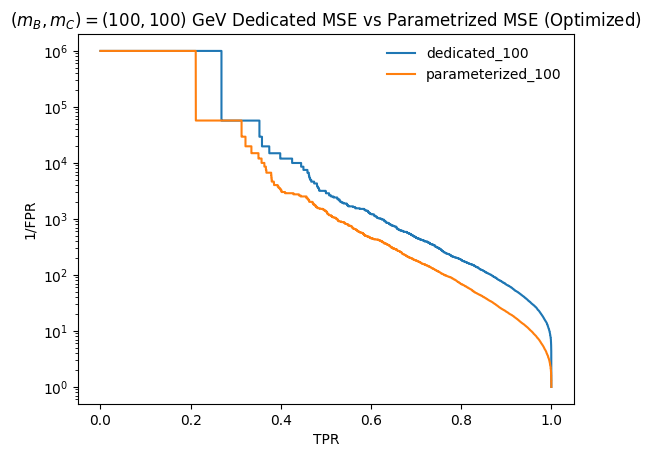

In [105]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE + epsilon),label="dedicated_100")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE + epsilon),label="parameterized_100")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE (Optimized)")

In [50]:
model_d = tf.keras.models.load_model("model_200_MSE_3_4096")

In [ ]:
preds_200 = model_d.predict(X_val_200,batch_size=1000)
fpr_200, tpr_200, _ = metrics.roc_curve(Y_val_200, preds_200)

Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE')

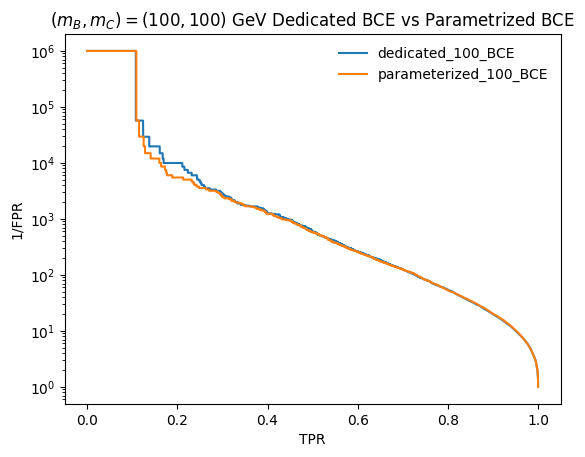

In [108]:
epsilon = 1e-6
plt.plot(tuple_rates_dedicated[(1,1)][1],1./(tuple_rates_dedicated[(1,1)][0] + epsilon),label="dedicated_100_BCE")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE + epsilon),label="parameterized_100_BCE")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE")

Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE')

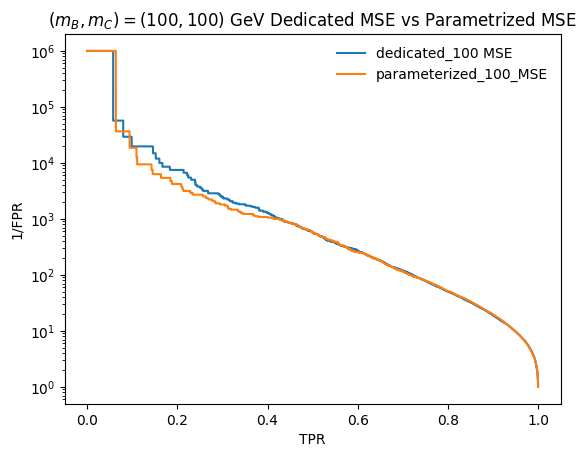

In [455]:
plt.plot(tpr_100_MSE,1./(fpr_100_MSE + epsilon),label="dedicated_100 MSE")
plt.plot(tpr_all_MSE,1./(fpr_all_MSE + epsilon),label="parameterized_100_MSE")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE")

In [247]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all_BCE.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_BCE(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [36]:
model_all_BCE = tf.keras.models.load_model("model_all_BCE_3_4096")
model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [ ]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all_BCE.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1.)
            model32 = createSimpleModel(4.)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all_BCE(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(x_vals_[:,0:4], y_vals_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

Epoch 1/10
192/192 [==============================] - 1s 5ms/step - loss: 0.9869 - val_loss: 0.7617
Epoch 2/10
192/192 [==============================] - 1s 4ms/step - loss: 0.7103 - val_loss: 0.6879
Epoch 3/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6838 - val_loss: 0.6872
Epoch 4/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.6872
Epoch 5/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.6872
Epoch 6/10
192/192 [==============================] - 1s 5ms/step - loss: 0.6840 - val_loss: 0.6874
Epoch 7/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6838 - val_loss: 0.6873
Epoch 8/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.6889
Epoch 9/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.6873
Epoch 10/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6840 - val_loss: 0.6873

In [274]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.51142263 6.7378454 ]
[0.5 1. ] [0.5973773 7.1714735]
[0.5 1.5] [1.5079887 7.4636626]
[1.  0.5] [0.6136622 7.126277 ]
[1. 1.] [0.986506  7.2390375]
[1.  1.5] [1.1053972 7.4967775]
[1.5 0.5] [1.5069221 7.5023656]
[1.5 1. ] [1.0532012 7.421378 ]
[1.5 1.5] [1.4985871 6.466111 ]
[4.  4.5] [2.8875525 4.4285445]
[4.5 4. ] [1.0387179 4.3993835]
[4.5 4.5] [1.0719916 4.5687556]
[4.5 5. ] [1.1336992 4.9292355]
[5.  4.5] [1.0286508 4.9457707]
[5. 5.] [3.8444164 5.1046042]
[5.  5.5] [1.2402148 5.479842 ]
[5. 6.] [1.5420388 5.764651 ]
[6.  5.5] [4.327569 5.898191]
[6. 6.] [4.787635 6.132607]
found both: 0.8680555555555556
found one: 0.125
found none: 0.006944444444444444


In [128]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

In [310]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

# max_SIC1 = []
# max_SIC2 = []

z = {}

epsilon = 1e-6
#sig_space = np.logspace(-3, -1, 20)
#for sigfrac in sig_space:

count = 0
for w1 in m1_list:
    for w2 in m2_list:
        if count == -1:
            break
        
        sigfrac = 0.05
        print("Signal Fraction: ", sigfrac)
        for l in model_all_MSE.layers:
            l.trainable=False

        model3 = createSimpleModel(w1)
        model32 = createSimpleModel(w2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all_MSE(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1 + sigfrac * LLR - sigfrac
        #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
        ws = LLR_xs / (1.+ LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))
        
        m1 = 3
        m2 = 4

        test_background = int(1/2 *len(x[0,0]))
        train_background = int(1/4 * len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        train_reference = int(1/4 * len(x[0,0]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2]))
        N = int(1/4 * (len(x[0,0])))
        signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0][test_background:],signal])
        #[reference (0), data_background (1), signal(1)]
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
        print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)
        
        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
        
        #myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
        
        sig_list+=[sigfrac]
        w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
        w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

        print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        count+=1
        
        z[w1, w2] = model_all2.evaluate(x_vals_, y_vals_)
        
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
#     max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#     max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
3 4 0.5 0.5
1937/1937 [==============================] - 3s 1ms/step - loss: 0.2505
Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
3 4 0.5 1.0
1937/1937 [==============================] - 3s 1ms/step - loss: 0.2500
Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
3 4 0.5 1.5
1937/1937 [==============================] - 3s 1ms/step - loss: 0.2484
Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
3 4 0.5 2.0
1937/1937 [==============================] - 2s 1ms/step - loss: 0.2474
Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
3 4 0.5 2.5
1937/1937 [==============================] - 3s 1ms/step - loss: 0.2468
Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
3 4 0.5 3.0
1937/1937 [==============================] - 3s 1ms/step - loss: 0.2463
Signal Fraction:  0.05
30232 90698 1511 0.049980153479756546
3 4 0.5 3.5
1937/1937 [==============================] - 3s 1ms/step 

In [ ]:
def train_and_plot_loss(model, train_data, validation_data, num_epochs):
    train_loss = []
    val_loss = []
    
    for epoch in range(num_epochs):
        history = model.fit(train_data, epochs=1, validation_data=validation_data, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        val_loss.append(history.history['val_loss'][0])
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")


In [306]:
myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
w1_out = model_all2.trainable_weights[0].numpy()[0][0]
w2_out = model_all2.trainable_weights[0].numpy()[0][0]
print(m1, m2, w1_out, w2_out)

Epoch 1/20
31/31 [==============================] - 0s 9ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 2/20
31/31 [==============================] - 0s 7ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 3/20
31/31 [==============================] - 0s 10ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 4/20
31/31 [==============================] - 0s 7ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 8/20
31/31 [==============================] - 0s 6ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.2457 - val_loss: 0.2452
Epoch 11/20
31/31 

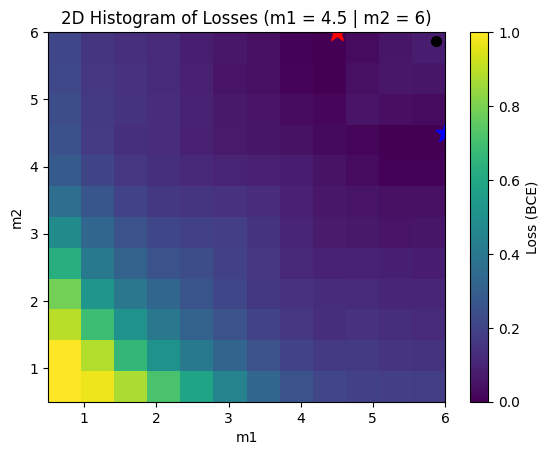

In [309]:
def loss_landscape_2D(m1, m2, w1_out, w2_out):
    m1_values, m2_values = zip(*z.keys())

    loss_values = list(z.values())
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]

    plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('2D Histogram of Losses (m1 = {}'.format(m1) + " | m2 = {})".format(m2))

    plt.show()
    
loss_landscape_2D(m1, m2, w1_out, w2_out)

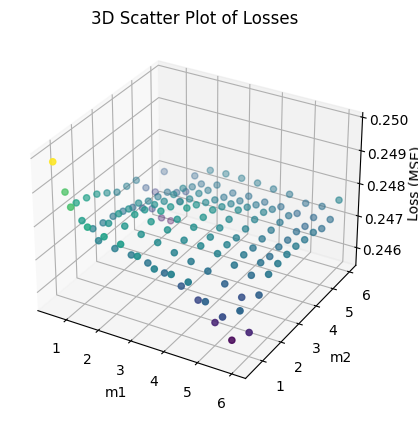

In [125]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

m1_values, m2_values = zip(*z.keys())

loss_values = list(z.values())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(m1_values, m2_values, loss_values, c=loss_values, cmap='viridis')

ax.set_xlabel('m1')
ax.set_ylabel('m2')
ax.set_zlabel('Loss (MSE)')
ax.set_title('3D Scatter Plot of Losses')

plt.show()

In [139]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

(0.0, 700.0)

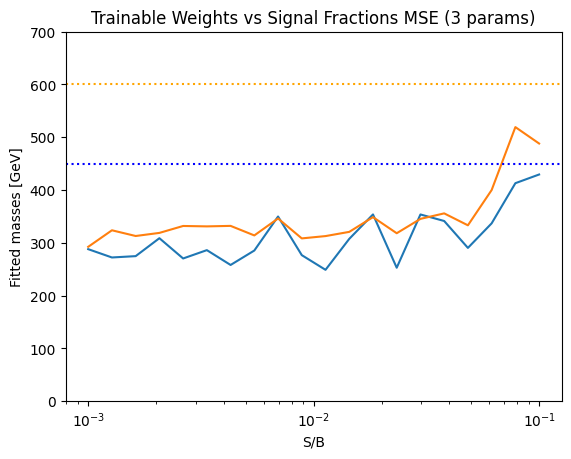

In [50]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (3 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

Text(0.5, 1.0, 'S/B vs Fitted S/B')

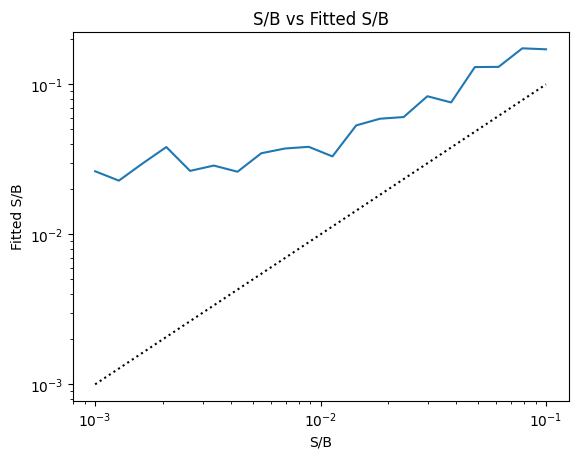

In [161]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")

In [7]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

In [244]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

test_list = []

epsilon = 1e-6

#sig_space = np.logspace(-3, -1, 20)
#for sigfrac in sig_space:
sigfrac = .05
print("Signal Fraction: ", sigfrac)
for l in model_all_BCE.layers:
    l.trainable=False

model3 = createSimpleModel(2)
model32 = createSimpleModel(3)

inputs_hold3 = tf.keras.Input(shape=(1,))
simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

inputs = tf.keras.Input(shape=(4,))
inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_BCE(inputs2)
LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
#LLR_xs = 1 + sigfrac * LLR - sigfrac 
#LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
#ws = (LLR_xs / (1.+ LLR_xs))
#term = (sigfrac * LLR + (1-sigfrac)/ws) - sigfrac * LLR + (1-sigfrac)
#ws2 = LLR_xs / ((1.+ LLR_xs) + term)
ws = (sigfrac * LLR + (1-sigfrac))/((sigfrac *LLR) + (2-sigfrac))
model_all2 = Model(inputs = inputs, outputs = ws)
model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

m1 = 4.5
m2 = 6

test_background = int(1/2 *len(x[0,0]))
train_background = int(1/4 * len(x[0,0]))
train_data = int(1/4 * len(x[0,0]))
train_reference = int(1/4 * len(x[0,0]))
#signal
test_signal_length = int(1/2*len(x[m1,m2]))
N = int(1/4 * (len(x[0,0])))
signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

x_vals_ = np.concatenate([x[0,0][test_background:],signal])
#[reference (1), data_background (0), signal(0)]
y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])

sig_list+=[sigfrac]
w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
#w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
fpr, tpr, _ = metrics.roc_curve(y, scores)

Signal Fraction:  0.05
<class 'keras.engine.keras_tensor.KerasTensor'>
30232 90698 1511 0.049980153479756546
Epoch 1/20
31/31 [==============================] - 1s 12ms/step - loss: 0.6870 - val_loss: 0.6861
Epoch 2/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6869 - val_loss: 0.6861
Epoch 3/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6869 - val_loss: 0.6860
Epoch 4/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6868 - val_loss: 0.6861
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6868 - val_loss: 0.6861
Epoch 6/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6867 - val_loss: 0.6861
Epoch 7/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6867 - val_loss: 0.6861
Epoch 8/20
31/31 [==============================] - 0s 7ms/step - loss: 0.6867 - val_loss: 0.6861
Epoch 9/20
31/31 [==============================] - 1s 19ms/step - loss: 0.6868 - val_loss: 0.6861
Epoch 1

In [241]:
model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

test = model_all2.predict(x_vals_)
len(test)

1937/1937 [==============================] - 2s 853us/step


61976

In [242]:
test

array([[0.4872209 ],
       [0.48730484],
       [0.48717946],
       ...,
       [0.99997973],
       [0.5183183 ],
       [0.7963921 ]], dtype=float32)

(0.0, 700.0)

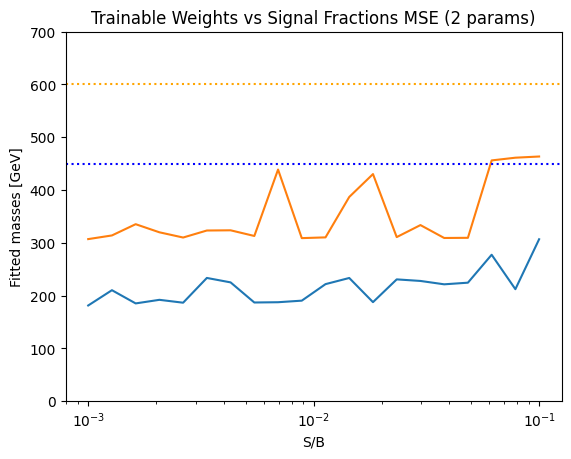

In [207]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

Signal Fraction:  0.001
Epoch 1/20
30/30 [==============================] - 1s 10ms/step - loss: 0.7152 - val_loss: 0.7074
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7066 - val_loss: 0.7026
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7026 - val_loss: 0.7003
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7004 - val_loss: 0.6989
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6979
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6971
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6972 - val_loss: 0.6966
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6967 - val_loss: 0.6962
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6958
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7125 - val_loss: 0.7093
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7046 - val_loss: 0.7041
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7011 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6980 - val_loss: 0.6989
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6972 - val_loss: 0.6982
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6975
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.6971
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6967
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6964
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7138 - val_loss: 0.7082
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7057 - val_loss: 0.7032
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7021 - val_loss: 0.7007
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7000 - val_loss: 0.6992
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6988 - val_loss: 0.6981
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6974
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6972 - val_loss: 0.6968
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6967 - val_loss: 0.6964
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6961
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6958
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7124 - val_loss: 0.7094
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7009 - val_loss: 0.7019
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.7004
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6977 - val_loss: 0.6993
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6985
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6979
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6974
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6970
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6967
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7139 - val_loss: 0.7081
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7056 - val_loss: 0.7033
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7019 - val_loss: 0.7007
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6992
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6986 - val_loss: 0.6982
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6975
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6969
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6965
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.6962
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6959
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7126 - val_loss: 0.7096
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7047 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7012 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6990
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6983
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6978
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6959 - val_loss: 0.6973
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6971
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6968
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7137 - val_loss: 0.7080
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7054 - val_loss: 0.7030
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7018 - val_loss: 0.7005
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6997 - val_loss: 0.6990
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6985 - val_loss: 0.6980
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6973
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6967
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6963
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6960
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6957
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7154 - val_loss: 0.7062
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7069 - val_loss: 0.7016
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7030 - val_loss: 0.6992
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7008 - val_loss: 0.6979
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6994 - val_loss: 0.6970
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.6964
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6977 - val_loss: 0.6959
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6956
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6953
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6950
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7122 - val_loss: 0.7088
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7042 - val_loss: 0.7037
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7008 - val_loss: 0.7012
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.6996
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6986
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6973
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6962
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7125 - val_loss: 0.7084
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7034
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7010 - val_loss: 0.7009
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6994
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6984
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6977
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6971
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6966
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6963
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6960
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 11ms/step - loss: 0.7111 - val_loss: 0.7093
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7035 - val_loss: 0.7040
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7002 - val_loss: 0.7013
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.6997
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6973 - val_loss: 0.6986
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6972
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6960
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7103 - val_loss: 0.7096
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7028 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6997 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6989
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6962 - val_loss: 0.6981
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6975
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6970
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6949 - val_loss: 0.6966
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6963
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7128 - val_loss: 0.7066
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7019
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7010 - val_loss: 0.6994
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6980
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6978 - val_loss: 0.6971
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6964
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6959
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6955
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6952
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6950
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7129 - val_loss: 0.7061
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7048 - val_loss: 0.7012
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7012 - val_loss: 0.6988
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.6973
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6964
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6957
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6953
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6949
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6946
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6944
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7096 - val_loss: 0.7075
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7022 - val_loss: 0.7025
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.7001
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6986
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6977
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6953 - val_loss: 0.6969
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6948 - val_loss: 0.6964
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6944 - val_loss: 0.6960
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6941 - val_loss: 0.6957
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6939 - val_loss: 0.6955
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 7s 213ms/step - loss: 0.7096 - val_loss: 0.7064
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7020 - val_loss: 0.7015
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6987 - val_loss: 0.6991
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6976
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6968
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6961
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6947 - val_loss: 0.6956
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6943 - val_loss: 0.6952
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6949
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6938 - val_loss: 0.6947
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 12ms/step - loss: 0.7092 - val_loss: 0.7050
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7014 - val_loss: 0.7004
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6981 - val_loss: 0.6982
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6969
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6961
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6945 - val_loss: 0.6955
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6950
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6936 - val_loss: 0.6947
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6945
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6943
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 13ms/step - loss: 0.7091 - val_loss: 0.7034
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7014 - val_loss: 0.6987
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6981 - val_loss: 0.6966
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6953
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6945
Epoch 6/20
31/31 [==============================] - 1s 28ms/step - loss: 0.6947 - val_loss: 0.6939
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6942 - val_loss: 0.6935
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6939 - val_loss: 0.6932
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6936 - val_loss: 0.6930
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6928
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 13ms/step - loss: 0.7075 - val_loss: 0.7020
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6976
Epoch 3/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6967 - val_loss: 0.6956
Epoch 4/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6951 - val_loss: 0.6945
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6941 - val_loss: 0.6938
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6929
Epoch 8/20
31/31 [==============================] - 1s 29ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 11ms/step - loss: 0.7049 - val_loss: 0.7009
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6966
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6947
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6936
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6923 - val_loss: 0.6929
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6918 - val_loss: 0.6924
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6914 - val_loss: 0.6921
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6912 - val_loss: 0.6919
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6910 - val_loss: 0.6917
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6908 - val_loss: 0.6916
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


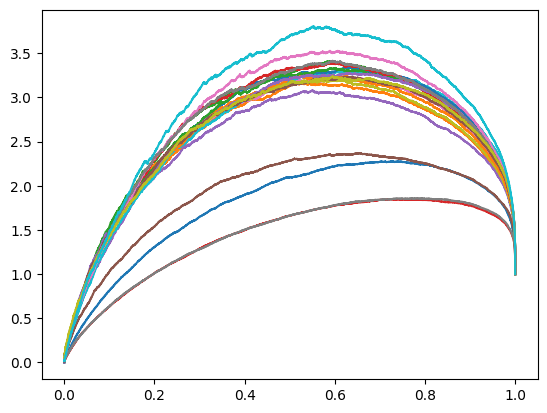

In [946]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_qq.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1 +sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3.5
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#    max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]